## Invasive species deep learning from kernels on kaggle

Christian Hansen  
Kaggle Project  
June 4, 2017

This is image classifcation problem looking at images with or without an invasive species of plant in Brazil. In the code I explore the images before and after with my predictions. The data provided from Kaggle inclduded a holdout set. I split the provided training data into it's own train and test set. This code is an amalgmation of https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html, using a VGG16 with frozen bottom layers and adding a new top layer to fine tune. 

In [38]:
ls

data/                             sample_submission.csv
Invasive_Species-Fine_tune.ipynb  sample_submission.csv.zip
Invasive_Species.ipynb            submit.csv
__MACOSX/                         VGG16-transferlearning.model
nohup.out                         vgg16weights/
ReadMe.txt


In [39]:
import pandas as pd
import numpy as np
import os
import cv2
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
# K.set_image_dim_ordering('th')
# dimesional ordering is confusing so I'm sticking to whatever the stock setup is.

Training and testing data, looking at the data we can see how the labeeled data looks.

In [3]:
trainpath = './data/train/'
testpath = './data/test/'
print('# of training files: ' + str(len(os.listdir(trainpath))))
print('# of testing files: ' + str(len(os.listdir(testpath))))

# of training files: 2300
# of testing files: 1533


In [4]:
train_labels = pd.read_csv('./data/train/train_labels.csv')
train_labels.head()

name  invasive
0     1         0
1     2         0
2     3         1
3     4         0
4     5         1

In [5]:
train_labels.shape

(2295, 2)

# Preview invasive and non-invasive plant images

Non-Invasive image example./data/train/1.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/2.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/4.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/6.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/9.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/10.jpg (Height:866 Width:1154)


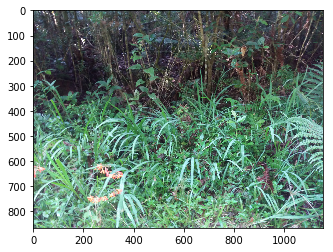

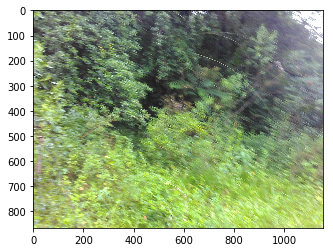

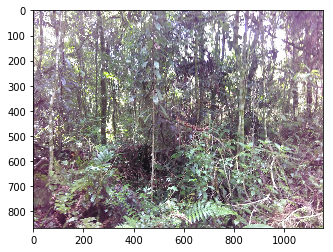

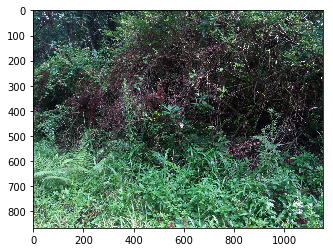

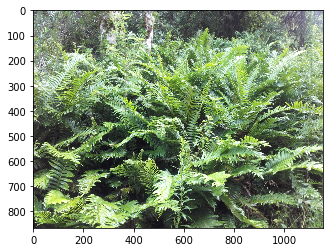

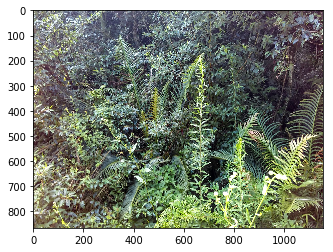

In [6]:
# Preview a few noninvasive plant images
for i in range(12):
#   print(train_labels.name[i], train_labels.invasive[i])
    sample_image = io.imread(trainpath + str(train_labels.name[i]) + '.jpg')
    if train_labels.invasive[i] < 1:
        print('Non-Invasive image example' + trainpath + str(train_labels.name[i]) + '.jpg (Height:{0} Width:{1})'.format(sample_image.shape[0], sample_image.shape[1]))
        plt.figure()
        plt.imshow(sample_image)

Invasive image example./data/train/3.jpg (Height:866 Width:1154)
Invasive image example./data/train/5.jpg (Height:866 Width:1154)
Invasive image example./data/train/7.jpg (Height:866 Width:1154)
Invasive image example./data/train/8.jpg (Height:866 Width:1154)
Invasive image example./data/train/11.jpg (Height:866 Width:1154)
Invasive image example./data/train/12.jpg (Height:866 Width:1154)


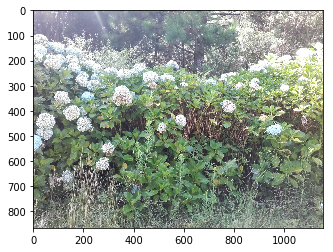

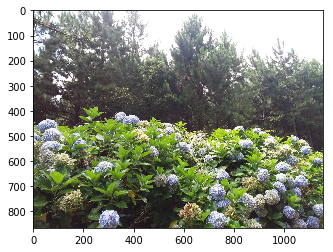

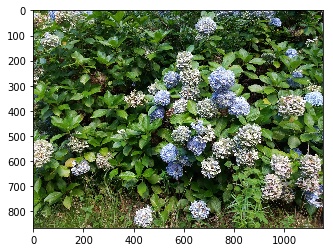

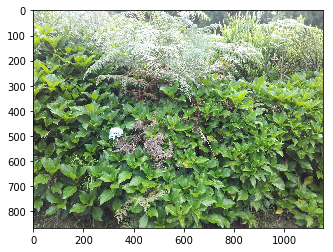

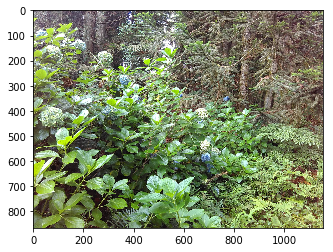

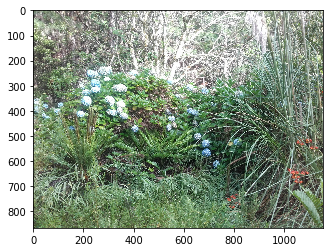

In [7]:
# Preview a few invasive plant images
for i in range(12):
#    print(train_labels.name[i], train_labels.invasive[i])
    sample_image = io.imread(trainpath + str(train_labels.name[i]) + '.jpg')
    if train_labels.invasive[i] > 0:
        print('Invasive image example' + trainpath + str(train_labels.name[i]) + '.jpg (Height:{0} Width:{1})'.format(sample_image.shape[0], sample_image.shape[1]))
        plt.figure()
        plt.imshow(sample_image)

# Scale and normalize the image for the training/fine-tuning the network

In [41]:
#scaling them down to 224x224 pixels to keep things simple.
ypix, xpix = 224, 224
ncol = 3
scaled = (xpix, ypix, ncol)
n_train = 2295

x_train = np.empty(shape=(n_train, xpix, ypix, ncol))
y_train = np.array(train_labels.invasive.values[0:n_train])

# for i in range(n_train):
#     tr_im = io.imread(trainpath + str(i+1) + '.jpg')
#     x_train[i] = transform.resize(tr_im, output_shape=scaled)

## Do the same manipulation to the test data

In [129]:
sample_submission = pd.read_csv("./sample_submission.csv")
img_path = "./data/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.ix[i][0])
    file_paths.append( img_path + str(int(sample_submission.ix[i][0])) +'.jpg' )
    
test_names = np.array(test_names)

test_images = []
for file_path in file_paths:
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     #out put 224*224px 
#     img = img[16:240, 16:240]
    test_images.append(img)
    
    path, ext = os.path.splitext( os.path.basename(file_paths[0]) )

test_images = np.array(test_images)

In [43]:
test_images = test_images.astype('float32')
# test_images /= 255

In [44]:
data_num = len(y_train)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(x_train[random_index[i]])
    y_shuffle.append(y_train[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

In [45]:
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (1836, 224, 224, 3)
y_train (1836,)
x_test (459, 224, 224, 3)
y_test (459,)


In [16]:
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

## Keras: loading the weights of the vgg16 model

In [46]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

#VGG16 model, with weights pre-trained on ImageNet.
#https://keras.io/applications/#vgg16
base_model = applications.VGG16(weights='imagenet',
                                include_top=False,
                                input_shape=(img_rows,
                                             img_cols, img_channel))
print('Model loaded.')

Model loaded.


## Keras: adding top layer

In [52]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

for layer in model.layers[:16]:
    layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Keras: preprocessing images and setting epochs to perform the training on the top layers.

In [114]:
#this part is a little ambiguous to me, but it does some pre-processing.
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 4

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_datagen.fit(x_train)

model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)


Epoch 1/4
57/57 [==============================] - 40s - loss: 0.3800 - acc: 0.8311 - val_loss: 0.3664 - val_acc: 0.8519

In [131]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# model = load_model('my_model.h5')

## Now that it's all trained up, I'll look into using the test set created earlier to evaluate my model before trying it out on the holdout set

In [115]:
# predict from x_test
predictions = model.predict(x_test)

## Evaluating model using ROC curve and Precision-Recall

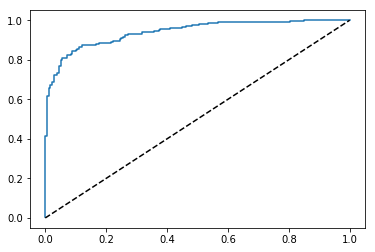

0.9403823178016727

In [116]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()
roc_auc_score(y_test,predictions)

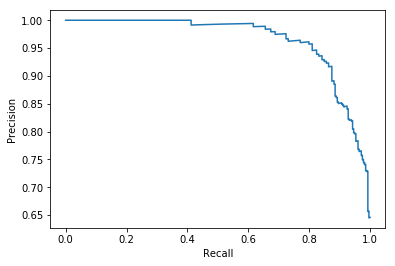

In [117]:
from sklearn.metrics import precision_recall_curve,average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
plt.plot(recall, precision)
average_precision_score(y_test, predictions)  
plt.xlabel('Recall')
plt.ylabel('Precision')

In [118]:
thresh = list(thresholds)
len(precision),len(thresholds),len(thresh)

(433, 432, 432)

In [122]:
thresh.append(1)
# len(thresh)

In [120]:
# thresh.pop()

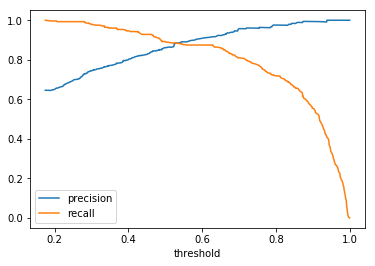

In [123]:
plt.plot(thresh,precision,label ='precision')
plt.plot(thresh,recall,label ='recall')
plt.xlabel('threshold')
plt.legend()

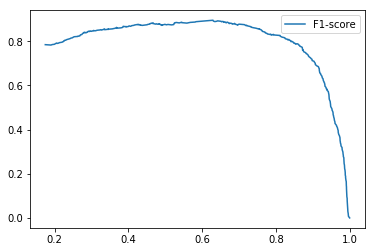

In [124]:
## plot F1 score
F1 = 2 *precision*recall/(precision+recall)
                          
plt.plot(thresh,F1,label = 'F1-score')
plt.legend()

This allows us to choose a threshold based on what our requirements for our model are. If we want less recall and more precision or a balance of the two, that is up to the team implementing the code.

"precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned"
Case 1:

High scores for both show that the classifier returns accurate results, higher precision and that the majority of positive results are true positives.

Case 2:

A System with high recall but low precision returns many results, but most of it's predictd lables are incorrect. 

Precision:
Tp < Tp + Fp 

Fp ---> big

The model detects many things as positive incorrectly

Recall:
Tp > Tp + Fn

Fn-->0 

there are very few false negatives, that is things that are classified as negative are actually positive.


Case 3:

A system with high precision but low recall has very few results that but most of the predicted labels are correct.

Precision:
Tp > Tp + Fp 

or Fp --> 0
Very few false positives

Recall;
Tp < Tp + Fn
Fn ---> big!
There are many False negatives in the model, things that are correct but mislabeled.

# Predict from holdout set and make a submission csv


In [125]:
predictions = model.predict(test_images)
for i, name in enumerate(test_names):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = predictions[i]

sample_submission.to_csv("submit.csv", index=False)

In [126]:
test_labels=pd.read_csv('submit.csv')
test_labels.head()

name  invasive
0     1  0.992698
1     2  0.735593
2     3  0.309070
3     4  0.000394
4     5  0.597986

# Now lets see how our predictions look!

Invasive image example./data/train/3.jpg (Height:866 Width:1154)
Invasive image example./data/train/4.jpg (Height:866 Width:1154)
Invasive image example./data/train/5.jpg (Height:866 Width:1154)
Invasive image example./data/train/6.jpg (Height:866 Width:1154)
Invasive image example./data/train/7.jpg (Height:866 Width:1154)
Invasive image example./data/train/10.jpg (Height:866 Width:1154)


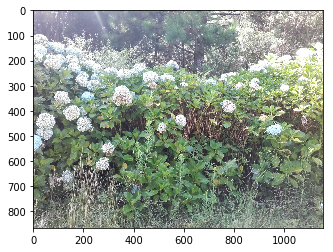

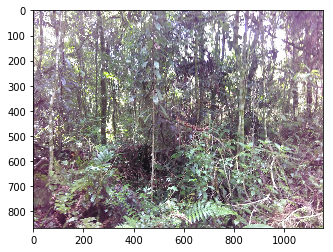

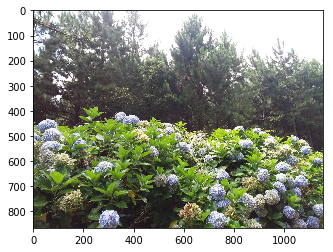

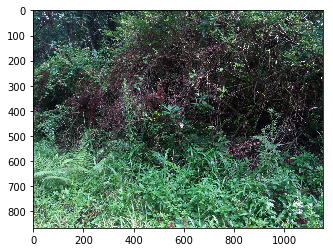

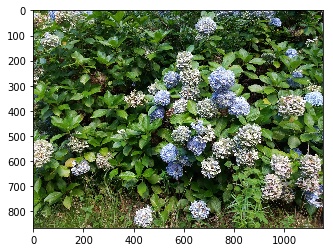

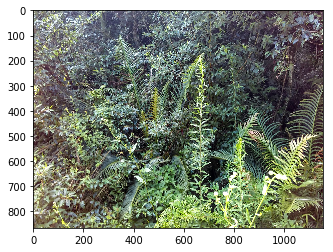

In [132]:
# This should be all non-invasive

test_path = './data/test/'
for i in range(12):
#    print(train_labels.name[i], train_labels.invasive[i])
    sample_image = io.imread(trainpath + str(test_labels.name[i]) + '.jpg')
    if test_labels.invasive[i] < 0.6:
        print('Invasive image example' + trainpath + str(test_labels.name[i])
              + '.jpg (Height:{0} Width:{1})'.format(sample_image.shape[0], sample_image.shape[1]))
        plt.figure()
        plt.imshow(sample_image)

Invasive image example./data/train/1.jpg (Height:866 Width:1154)
Invasive image example./data/train/2.jpg (Height:866 Width:1154)
Invasive image example./data/train/8.jpg (Height:866 Width:1154)
Invasive image example./data/train/9.jpg (Height:866 Width:1154)
Invasive image example./data/train/11.jpg (Height:866 Width:1154)
Invasive image example./data/train/12.jpg (Height:866 Width:1154)
Invasive image example./data/train/13.jpg (Height:866 Width:1154)
Invasive image example./data/train/14.jpg (Height:866 Width:1154)
Invasive image example./data/train/15.jpg (Height:866 Width:1154)
Invasive image example./data/train/17.jpg (Height:866 Width:1154)
Invasive image example./data/train/18.jpg (Height:866 Width:1154)
Invasive image example./data/train/19.jpg (Height:866 Width:1154)


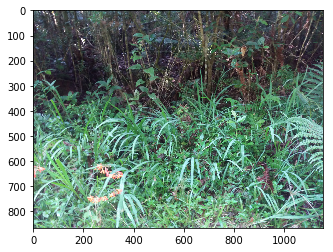

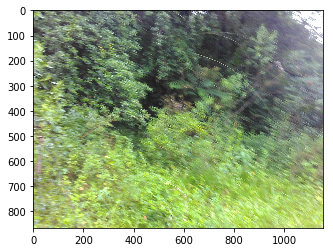

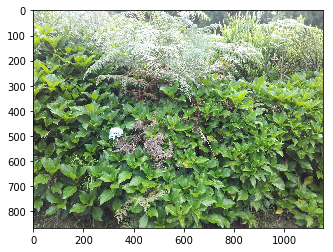

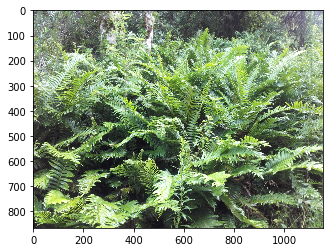

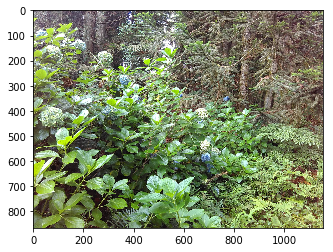

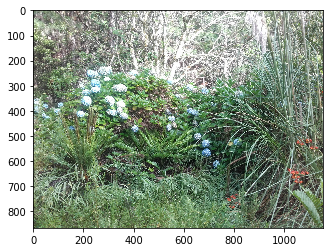

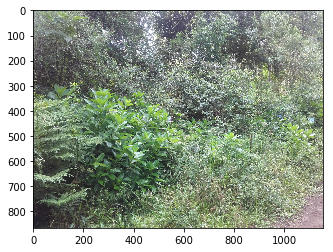

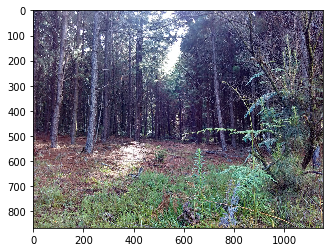

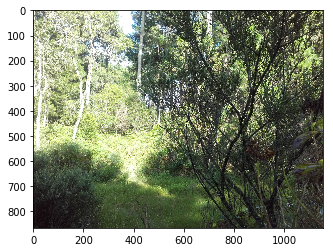

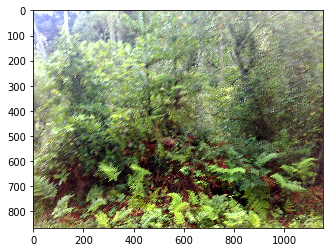

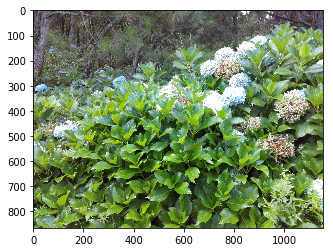

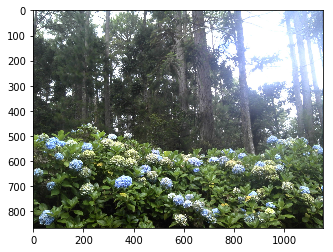

In [134]:
## This should show invasive species
test_path = './data/test/'
for i in range(0,20):
#    print(train_labels.name[i], train_labels.invasive[i])
    sample_image = io.imread(trainpath + str(test_labels.name[i]) + '.jpg')
    if test_labels.invasive[i] > 0.6:
        print('Invasive image example' + trainpath + str(test_labels.name[i])
              + '.jpg (Height:{0} Width:{1})'.format(sample_image.shape[0], sample_image.shape[1]))
        plt.figure()
        plt.imshow(sample_image)

## The model seems strong after a few epochs, but can be run for much longer and improve the predictions.